# 프로젝트 : SRGAN 활용하기

# ✅ 목차

-----------------

### 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
   * 프로젝트 1-1
   * 프로젝트 1-2

### 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
   * 1) gif 파일 불러오기
   * 2) 프레임별 Super Resolution 진행하기
   * 3) 프레임을 합쳐 gif 만들기
   * 4) Jupyter notebook에 gif 표시하기

## ⭐️ 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 프로젝트 1-1.

----------------------------------

**1.**  (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
 
**2.**   불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.

**3.**   줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

**4.**   2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

**5.**   3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

**6.**   선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image

1382784


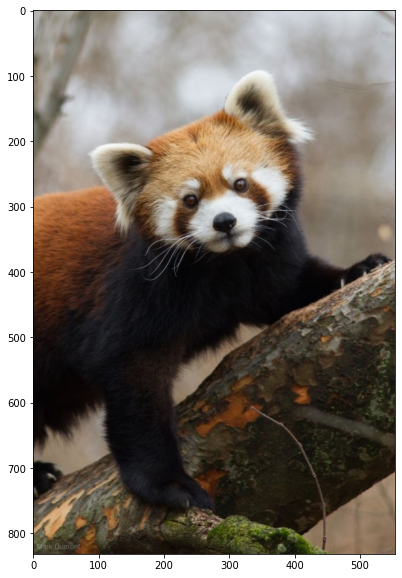

In [2]:
# 고해상도 이미지인 레서판다 사진을 가져오겠습니다!
image_path = cv2.imread(os.getenv('HOME')+'/aiffel/super_resolution/image/lesser_panda.jpg')
hr_img = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)

print(hr_img.size)
plt.figure(figsize=(30,10))
plt.imshow(hr_img)

(208, 138, 3)


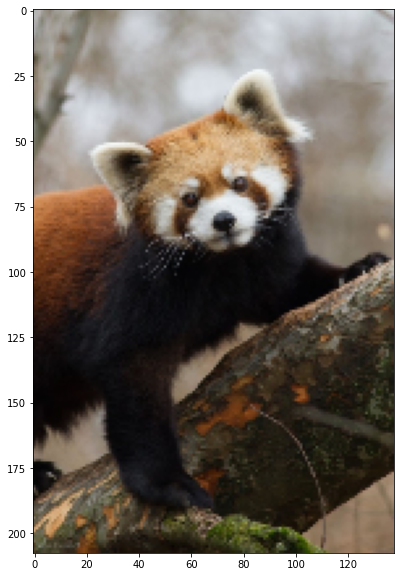

In [3]:
# 이미지 사이즈를 cv2.resize()를 사용해서 1/4 줄여서 해상도를 낮춰보겠습니다!!
lr_img = cv2.resize(
    hr_img,
    dsize=(hr_img.shape[1]//4, hr_img.shape[0]//4)
)

print(lr_img.shape)

plt.figure(figsize=(15,10))
plt.imshow(lr_img)

#### SRGAN학습!! 고해상도 이미지를 생성해볼께요!!

-----------------------

* **srgan_G.h5** 파일은 학습이 완료된 Generator
* SRGAN은 크게 두 개의 신경망(Generator, Discriminator)으로 구성되어 있지만, 테스트에는 저해상도 입력을 넣어 고해상도 이미지를 출력하는 Generator만 이용

In [4]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
# 저해상도 이미지를 입력받아 SRCNN으로 고해상도 이미지를 생성하는 함수
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)# tf.clip_by_value :텐서 값을 지정된 최소 및 최대로 자릅니다.
    sr = tf.round(sr) # 텐서의 값을 요소별로 가장 가까운 정수로 반올림
    sr = tf.cast(sr, tf.uint8) # tf.cast : 텐서를 새로운 형태로 캐스팅하는데 사용
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr_img)

In [6]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_img, 
    dsize=(hr_img.shape[1], hr_img.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

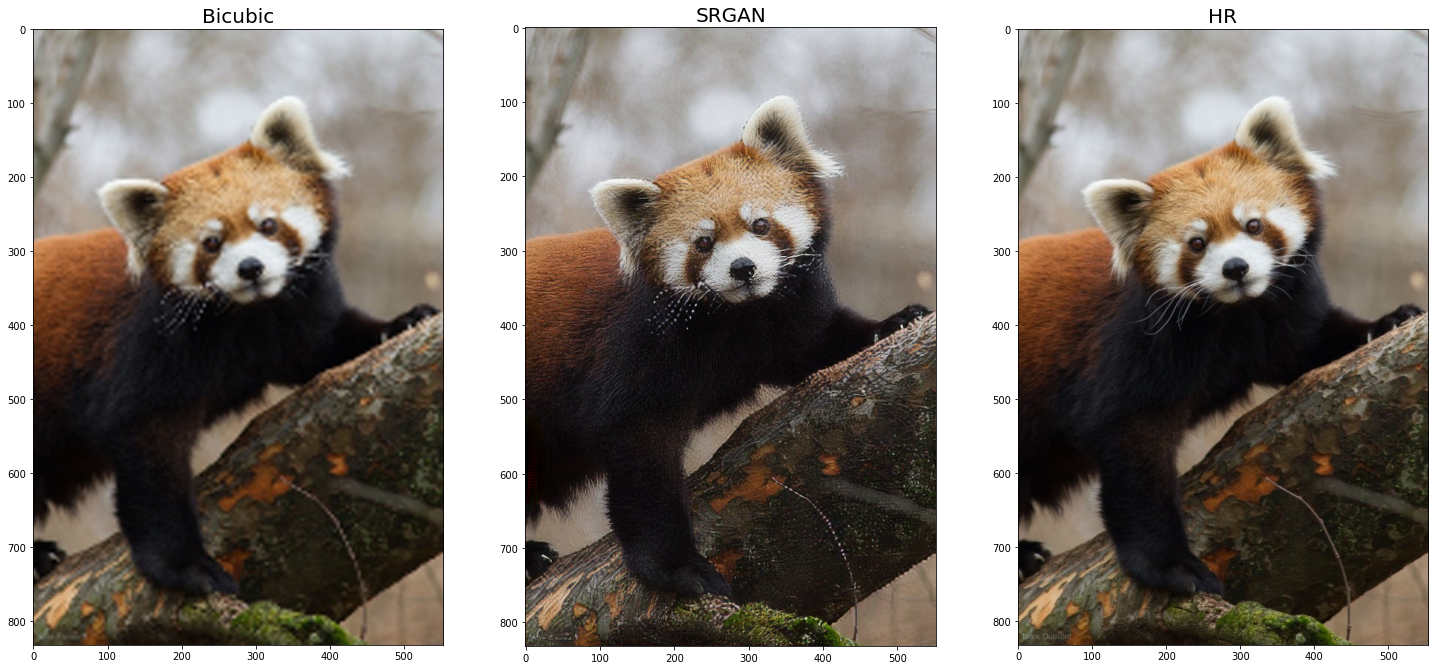

In [7]:
# 시각화
images = [bicubic_hr, srgan_hr, hr_img]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(25,15))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

이제 특정 영역을 잘라서 자세하게 비교해보겠습니다!!!

In [8]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

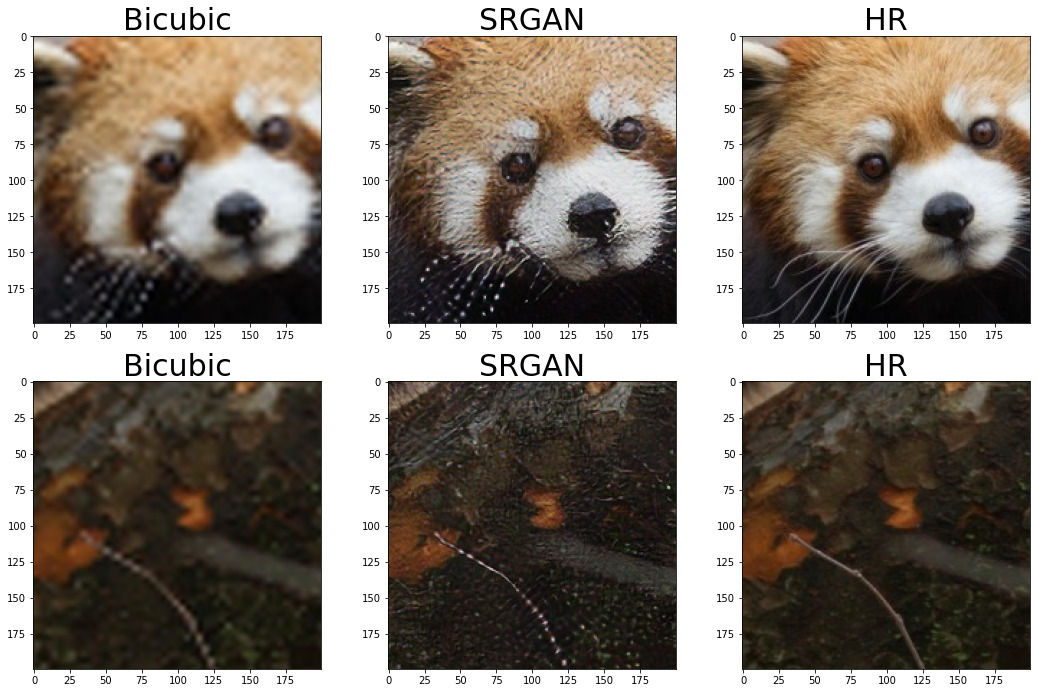

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 2개 입니다.
left_tops = [(200,150),(500,300)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_img, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

▶️ Bicubic : bicubic의 결과 , SRGAN : srgan의 결과, HR : 원래 이미지 

bicubic interpolation을 적용한 첫 번째 이미지는 보이는 것과 같이 좀 흐리게 나왔다.     
반면에 srgan 이미지는 비교적 선명해 보이고 질감이 두드러지게 잘 보인다.    
원래 고화질 이미지하고 비교해보면 코 옆에 털 부분이 끊기듯이 표현되는 등 이런 것도 볼 수 있었다.

### 프로젝트 1-2.

------------------------

**1.** (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

**2.** 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

**3.** 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.

**4.** 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

**5.** 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(300, 450, 3)


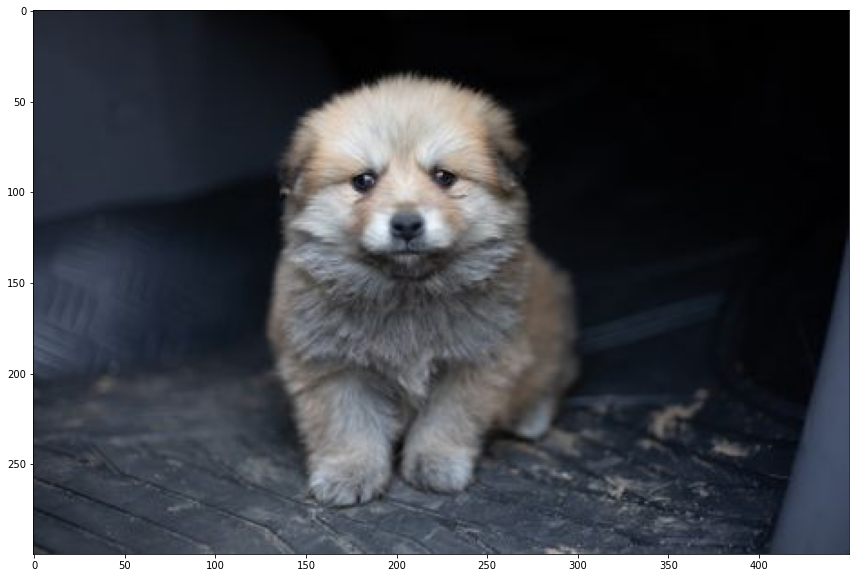

In [10]:
# 저해상도 이미지 불러오기
image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/image/dog3.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

plt.figure(figsize=(30,10))
plt.imshow(image)

적당히 낮은 해상도를 가진 귀여운 강아지 이미지를 저장 후에 불러왔습니다!!

In [11]:
# SRGAN으로 고해상도 이미지 생성
srgan_hr = apply_srgan(image)

In [12]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

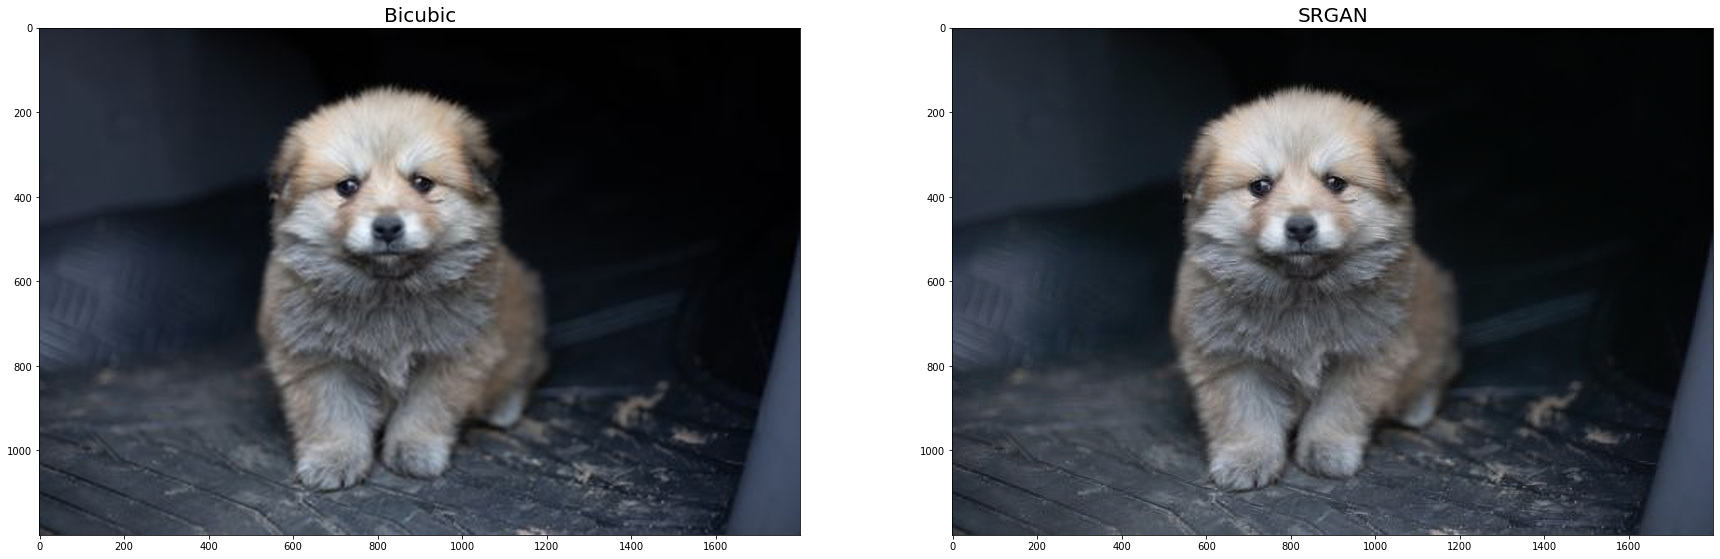

In [13]:
# 시각화를 해봅시다!
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(30,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

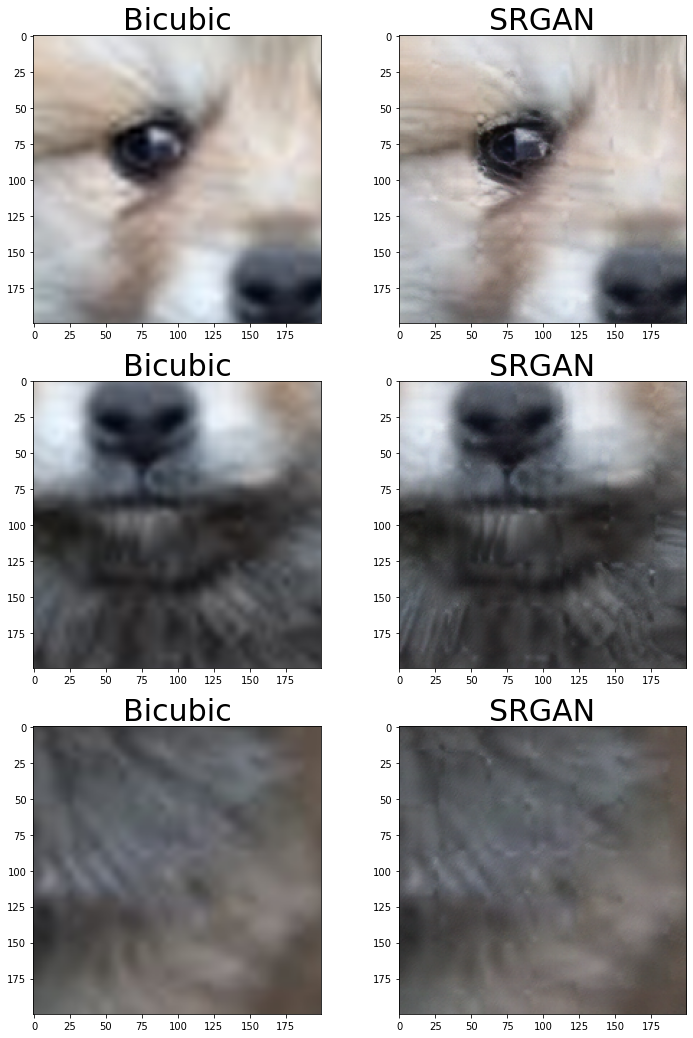

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(300,650), (450,750), (650,900)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

강아지 눈 부분을 보면 SRGAN쪽이 뭔가 더 선명해보이는 느낌이 나지만 다른 부분을 비교해보면 크게 차이가 있지는 않은 것 같다.

## ⭐️프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

### 1) gif 파일 불러오기

---------------------------

[GIF files](https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e)

In [15]:
import cv2
import os

gif_path = os.getenv('HOME') + '/aiffel/super_resolution/gif'
gif = cv2.VideoCapture(os.path.join(gif_path, 'wine_lr.gif'))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (340, 355, 3)


### 2) 프레임별 Super Resolution 진행하기

In [16]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [17]:
frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

### 3) 프레임을 합쳐 gif 만들기

In [39]:
import imageio

imageio.mimsave(os.path.join(gif_path, 'wine_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'wine_hr_srgan.gif'), frames_sr_srgan)

### 4) Jupyter notebook에 gif 표시하기

----------

저해상도 및 고해상도 시각화의 width 값은 같도록 설정

In [26]:
from IPython.display import Image as show_gif

#show_gif(os.path.join(gif_path, 'wine_lr.gif'), width=800) # width 는 적당히 큰 값으로 설정해주세요

In [27]:
#show_gif(os.path.join(gif_path, 'wine_hr_bicubic.gif'), width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

In [28]:
#show_gif(os.path.join(gif_path, 'wine_hr_srgan.gif'), width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

용량이 너무 커서 주석처리 했습니다!

### 다른 파일에도 적용해 보겠습니다

In [20]:
def gif_super_resolution(filename):
    gif = cv2.VideoCapture(os.path.join(gif_path, filename))

    isTrue = True
    frames = []
    while isTrue:
        isTrue, frame = gif.read()
        if isTrue:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    print("frame 수 :", len(frames))
    print("frame 크기 :", (frames[0].shape))

    frames_sr_bicubic = []
    for frame in frames:
        frames_sr_bicubic.append(cv2.resize(
            frame, 
            dsize=(frame.shape[1]*4, frame.shape[0]*4), 
            interpolation=cv2.INTER_CUBIC
        ))
        
    frames_sr_srgan = []
    for frame in frames:
        frames_sr_srgan.append(apply_srgan(frame))
    
    return frames_sr_bicubic, frames_sr_srgan

In [23]:
frames_sr_bicubic, frames_sr_srgan = gif_super_resolution('city_night_lr.gif')
imageio.mimsave(os.path.join(gif_path, 'city_night_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'city_night_hr_srgan.gif'), frames_sr_srgan)

frame 수 : 8
frame 크기 : (255, 500, 3)


In [24]:
frames_sr_bicubic, frames_sr_srgan = gif_super_resolution('book_lr.gif')
imageio.mimsave(os.path.join(gif_path, 'book_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'book_hr_srgan.gif'), frames_sr_srgan)

frame 수 : 22
frame 크기 : (215, 380, 3)


몇 개의 파일이 용량이 너무 커서 깃허브에 안 올라가기 때문에 구글드라이브에 넣었습니다!!

바로 보이게 할 수 없어서 슬프네요ㅜ

## gif 생성 링크

https://drive.google.com/drive/folders/1DSlbwE4y2QkDxIEtRL7_XsHjwqH2mv9e?usp=sharing

# 🌟 루브릭

|평가문항|상세기준|
|:----|:----|
|1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.|SRGAN을 통해 생성된 이미지를 제출하였다.|
|2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.|이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.|
|3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.|저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.|

# 🌟 회고

▶️ Error :
> oom when allocating tensor with shape[1,832,552,64] and type float on /job:localhost/replica:0/task:0/device:gpu:0 by allocator gpu_0_bfc [[{{node model_3/p_re_lu_26/relu_1-0-0-transposenchwtonhwc-layoutoptimizer}}]] hint: if you want to see a list of allocated tensors when oom happens, add report_tensor_allocations_upon_oom to runoptions for current allocation info. [op:__inference_predict_function_3677] function call stack: predict_function   

- def apply_srgan(image)(저해상도 이미지를 입력받아 SRCNN으로 고해상도 이미지를 생성하는 함수)를 수행할 때 위와 같은 에러가 났었는데, 구글링과 다른분들의 의견을 참고해서 여러 방법을 시도 했다. 첫 번째로는 이미지 크기를 줄이는거였는데 원래 이미지 크기가 그렇게 큰 편이 아니였고 줄여봐도 별 다른 점이 없어서 패스 했다. 
- gpu는 lms안에서 학습하는거라서 그것도 패스했다. 
- 결국에는 다시 재로그인 후 셧다운하고 다시 시작해보았는데 허무하게 이 에러가 사라졌다....

[에러참고](https://www.inflearn.com/questions/175633)
    
▶️ 알게된 점 : cv2.INTER_CUBIC에 대해서 찾아보던 중에 사이즈를 늘릴 때 사용하는 것 중 cv2.INTER_LINEAR도 있다는 것을 알게 되었다. cv2.INTER_LINEAR는 cv2.INTER_CUBIC보다 빠르고 권장한다고 한다.

[참고1](https://bigdata-analyst.tistory.com/205)
[참고2](https://bskyvision.com/712)

▶️ 느낀점 : 여러 에러들과 뭐가 문제인지 모르겠는 에러로 힘들었지만 끝까지 마무리 할 수 있어서 행복합니다..!! 마지막에 gif파일이 보이게 하는 부분을 (진영님👍이 알려주신 정보를 우용님👍이 알려주시고 그 정보를 습득하신)현지님👍(감사합니다😆)께서 저에게 알맞은 해결방안을 알려주셨지만ㅜㅜ 몇 개의 파일이 올라가지 않아서 해결하지 못한게 매우 아쉬웠습니다.     
SRGAN에 대해서 좀 더 내용을 찾아보면서 추가로 공부해야겠습니다!

# 🌟 참고

[진영님 깃허브](https://github.com/JYnote/AIFFEL_INCHEON/blob/main/EXPLORATION/Exploration_16/SRGAN.ipynb)     

[kec0130 깃허브](https://github.com/kec0130/AIFFEL-project/blob/main/exploration/E16_srgan_pjt.ipynb)    

[miinkang 깃허브](https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BE-16%5DSRGAN_super_resolution.ipynb)

[srgan참고](https://aigong.tistory.com/51)